In [2]:
#import libraries
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel

import requests
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from wordcloud import WordCloud

In [3]:
#load in dataset
subreddits = pd.read_csv('data/subreddits_aus.csv', index_col=False)
subreddits = subreddits[subreddits.subreddit != 'AskAnAustralian']

In [4]:
# tokenize the body of the text
def tokenize(text):
    punctuations = '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    unicodes = u'\xa0'
    newline_trailing = u'\n'
    for punctuation in punctuations:
        text = text.replace(punctuation, '')
        text = text.replace(unicodes, u' ')
        text = text.replace(newline_trailing, u' ')
        text = text.lower()
    return text

subreddits['tokenized_body'] = [tokenize(body) for body in subreddits['body']]

In [5]:
#Further preprocessing with spacy
doc = [text for text in nlp.pipe(subreddits.tokenized_body,
                                 disable=["ner",
                                          "parser"])]

subreddits['tokenized_body'] = [[word.lemma_.lower() for word in processed_text if
                   not word.is_stop] for processed_text in doc]

In [6]:
#Vectorizing
MIN_DF = 1 # minimum document frequency
MAX_DF = 0.8 # maximum document frequency

dictionary = Dictionary(subreddits['tokenized_body']) # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF,
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in subreddits['tokenized_body']]

In [7]:
#Train model 4 model with different N topics
PATH_TO_MALLET = 'mallet-2.0.8/bin/mallet'

N_TOPICS_20 = 20
N_ITERATIONS = 1000
lda20 = LdaMallet(PATH_TO_MALLET,
                  corpus=corpus,
                  id2word=dictionary,
                  num_topics=N_TOPICS_20,
                  optimize_interval=10,
                  iterations=N_ITERATIONS)

N_TOPICS_30 = 30
N_ITERATIONS = 1000
lda30 = LdaMallet(PATH_TO_MALLET,
                  corpus=corpus,
                  id2word=dictionary,
                  num_topics=N_TOPICS_30,
                  optimize_interval=10,
                  iterations=N_ITERATIONS)

N_TOPICS_50 = 50
lda50 = LdaMallet(PATH_TO_MALLET,
                  corpus=corpus,
                  id2word=dictionary,
                  num_topics=N_TOPICS_50,
                  optimize_interval=10,
                  iterations=N_ITERATIONS)

N_TOPICS_70 = 70
lda70 = LdaMallet(PATH_TO_MALLET,
                  corpus=corpus,
                  id2word=dictionary,
                  num_topics=N_TOPICS_70,
                  optimize_interval=10,
                  iterations=N_ITERATIONS)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 802
total tokens: 4835
<10> LL/token: -9.95993
<20> LL/token: -9.83075
<30> LL/token: -9.74956
<40> LL/token: -9.68676

0	2.5	flag indigenous ban sydney happen queer show day article write white hrt mention yesterday wear wake complain attend result xb 
1	2.5	coalition gay chinese public work commission moment fund legal vote order action lgbtq candidate pay give debt attack friendlyjordie rule 
2	2.5	australian news company big police tax family buy private turn set colour brother receive trip pyne liu joyce reject dose 
3	2.5	month minister party payer run grant refuse award travel defence pay force role dutton pm official claim office photo charge 
4	2.5	government support country sign law send funding poll finally evidence samesex happen environment business freedom recovery birth hate million voter 
5	2.5	feel staff work post community pride language great today team hear death nonindigenous culture vie

In [8]:
cv20 = CoherenceModel(model=lda20, texts=subreddits['tokenized_body'], dictionary=dictionary, coherence='c_v')
cv30 = CoherenceModel(model=lda30, texts=subreddits['tokenized_body'], dictionary=dictionary, coherence='c_v')
cv50 = CoherenceModel(model=lda50, texts=subreddits['tokenized_body'], dictionary=dictionary, coherence='c_v')
cv70 = CoherenceModel(model=lda70, texts=subreddits['tokenized_body'] , dictionary=dictionary, coherence='c_v')

/Users/nelly-ashleynyarko/opt/anaconda3/envs/PPM_individual/lib/python3.9/site-packages/gensim/models/wrappers/ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


In [9]:
# print coherence values to determine best topic number in this case
print(cv20.get_coherence(), cv30.get_coherence(), cv50.get_coherence(), cv70.get_coherence()) #best topic number lda70

0.5108942007234544 0.49101859789176455 0.5319908254342594 0.5193895378128077


In [11]:
# topic distribution
lda_t_50 = lda50.load_document_topics()
# topic distribution
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in lda_t_50],
                                   columns=['topic_{}'.format(i) for i in range(42)])
# joining dataframe
joined_topic_dist = subreddits.reset_index().join(topic_distributions)

# displaying mean per topic with topic 20 being the highest
joined_topic_dist.mean().sort_values(ascending=False)

/var/folders/35/9z_r08md09j_b9z46b8xdlnh0000gn/T/ipykernel_11902/1143868615.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  joined_topic_dist.mean().sort_values(ascending=False)


score           7272.126667
num_comments     364.360000
index            173.500000
topic_0            0.200781
topic_31           0.164278
topic_11           0.055624
topic_1            0.041167
topic_20           0.040826
topic_34           0.035241
topic_39           0.033532
topic_26           0.025938
topic_21           0.023840
topic_23           0.022371
topic_25           0.021576
topic_29           0.021430
topic_28           0.019678
topic_40           0.019599
topic_19           0.018448
topic_14           0.018076
topic_36           0.017506
topic_35           0.017008
topic_30           0.015587
topic_33           0.014785
topic_2            0.014264
topic_12           0.013060
topic_16           0.011633
topic_3            0.011174
topic_37           0.011138
topic_7            0.010859
topic_8            0.010273
topic_32           0.009822
topic_24           0.009585
topic_18           0.009123
topic_17           0.008520
topic_9            0.008415
topic_6            0

In [21]:
# words with the largest proportion
topics = lda50.show_topic(31, topn=len(dictionary))
df_topics = pd.DataFrame(topics, columns=['word', 'proportion'])
df_topics.sort_values('proportion', ascending=False).head(20)

word  proportion
0            term    0.067669
1           staff    0.037594
2            team    0.030075
3   nonindigenous    0.030075
4      whitefulla    0.030075
5        language    0.030075
6      blackfulla    0.022556
7         culture    0.022556
8            work    0.022556
16      offensive    0.015038
23         offend    0.015038
22          proud    0.015038
21           hurt    0.015038
20        context    0.015038
18       cultural    0.015038
17          speak    0.015038
19        manager    0.015038
15           word    0.015038
13   organisation    0.015038
12          story    0.015038

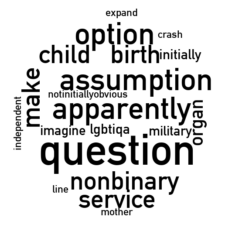

In [22]:
def black_circle():
    response = requests.get('https://i.ibb.co/kHNWRYD/black-circle-better.png')
    circle_mask = np.array(Image.open(BytesIO(response.content)))
    return circle_mask


#viz time!
list_of_topics = [0, 31, 11, 1, 20]
for topic_number in list_of_topics:
    TOPIC2PLOT = topic_number
    MAX_WORDS = 20
    circle_mask = black_circle()
    wordcloud = WordCloud(background_color='#fff',
                      font_path='/System/Library/Fonts/Supplemental/DIN Alternate Bold.ttf',
                      color_func=lambda *args, **kwargs: (0,0,0),
                      mask=circle_mask)
    wordcloud.generate_from_frequencies(frequencies=dict(lda50.show_topic(TOPIC2PLOT, MAX_WORDS)))

    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f'topic_viz/topic_{topic_number}.png')